In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sterilenu import *
from binned_analysis import *
from global_variables import *
import matplotlib.pyplot as plt
from multiprocess import Pool

from tqdm.auto import tqdm
from matplotlib.colors import LogNorm
import osc

/Users/gputnam/Work/NuTelescopeMuCollider/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
Rbin_width = 30 # m
Rbins = np.linspace(0,RADIUS,int(RADIUS/Rbin_width))
Ebins = np.linspace(Emuon/10,Emuon,10)


dm41s = np.logspace(-2, np.log10(25), 40)
dm41s = np.logspace(np.log10(25), np.log10(100), 10)

dm41s = np.array(list(np.logspace(-2, np.log10(25), 40)) + list(np.logspace(np.log10(25), np.log10(100), 10)))

th42s = np.logspace(-4, np.log10(np.arcsin(np.sqrt(0.1))/2), 40)

In [4]:
dmtest = 100
th24test = np.arcsin(np.sqrt(1e-2))/2
Enus = np.linspace(Emuon/10, Emuon, 500)

In [5]:
# for iexp, exp in enumerate(experiment_list):
#     plt.figure(iexp)
    
    
#     baseline = baseline_list[exp]
    
#     o = osc.oscillate(Enus, baseline, 1, -1, dL=10, dm41=dmtest, th24=th24test)
#     o = (np.abs(o)**2 / np.sum(np.abs(o)**2, axis=0))

#     SM = osc.oscillate(Enus, baseline, 1, -1, dL=100)
#     SM = (np.abs(SM)**2/ np.sum(np.abs(SM)**2, axis=0))
    
#     plt.plot(Enus, o[1], color="tab:blue")
#     plt.plot(Enus[4:], moving_average(o[1], 5), color="tab:blue", linestyle=":")
#     plt.plot(Enus, SM[1], color="tab:orange")
#     plt.plot(Enus[4:], moving_average(SM[1], 5), color="tab:orange", linestyle=":")
#     plt.title(exp)

In [6]:
dEnus = Enus[1] - Enus[0]
dEnus

np.float64(9.018036072144298)

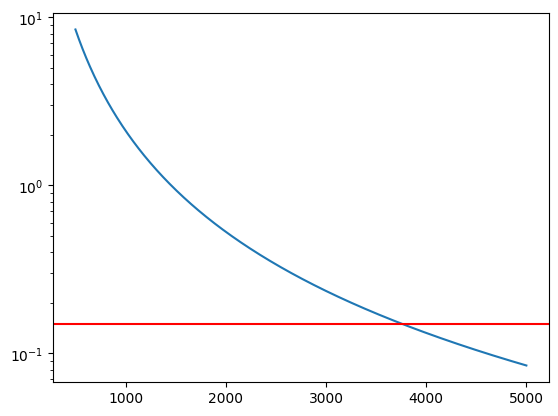

In [7]:
plt.plot(Enus, 100*1.27*baseline_list["IC"]*dEnus / 1e3 / Enus**2 / (2*np.pi))
plt.yscale("log")
plt.axhline(0.15, color="red")

In [16]:
def get_th42_chi2s(tup):
    idm, dm41 = tup
    
    dchi2s = {}
    for exp in experiment_list:
        dchi2s[exp] = np.zeros((th42s.size, ))
    for j, th42 in enumerate(th42s):
        dc2s = get_delta_chisquare_sterilenu(Rbins, Ebins, dm41, th42, sigmaUncorr=0.005)
        for exp in dc2s.keys():
            dchi2s[exp][j] = dc2s[exp]
    return idm, dchi2s
    

In [17]:
# get_th42_chi2s((0, 1))

In [18]:
dchi2s = {}
for exp in experiment_list:
    dchi2s[exp] = np.zeros((th42s.size, dm41s.size))

with Pool(10) as p:
    for i, dchi2 in tqdm(p.imap_unordered(get_th42_chi2s, enumerate(dm41s)), total=len(dm41s)):
        for exp in experiment_list:
            dchi2s[exp][:, i] = dchi2[exp]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 131.27it/s]


/var/folders/8y/rb4m2d3j4z3fprk2tgbc0sbr0000j6/T/ipykernel_68852/3240121374.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  p = plt.contour(X,Y, dchi2s[exp].T, levels=[3.84], colors="red", label=["95% CL"])


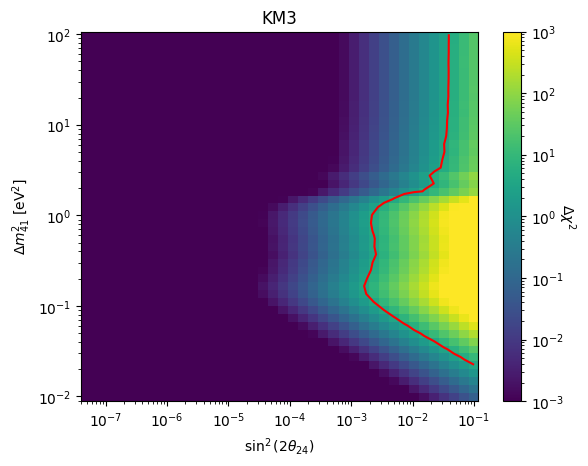

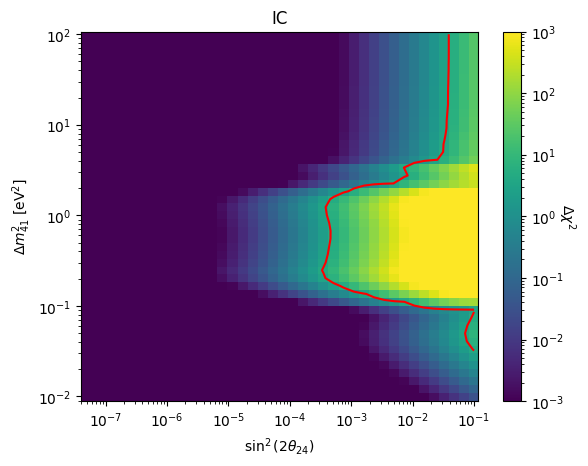

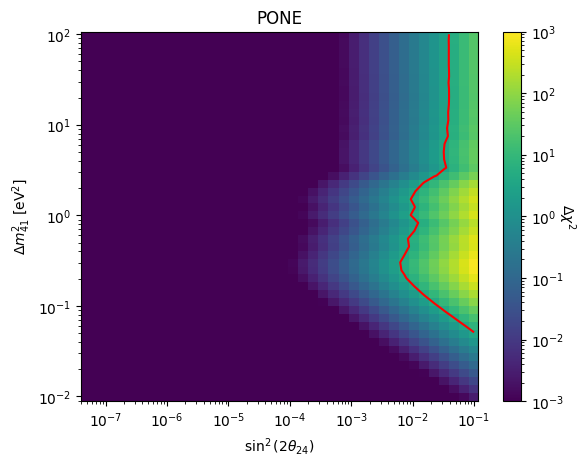

In [19]:
cl95 = []

for iexp, exp in enumerate(experiment_list):
    plt.figure(iexp)
    X,Y=np.meshgrid(np.sin(2*th42s)**2, dm41s)
    
    im = plt.pcolor(X,Y, dchi2s[exp].T, shading="nearest", norm=LogNorm(vmax=1e3, vmin=1e-3))
    cbar = plt.colorbar()
    cbar.set_label("$\\Delta\\chi^2$", rotation=-90, labelpad=10)
    
    # plt.axvline(100, color='red')
    p = plt.contour(X,Y, dchi2s[exp].T, levels=[3.84], colors="red", label=["95% CL"])
    cl95.append(p)
    plt.xlabel("$\\sin^2\\left(2\\theta_{24}\\right)$")
    plt.ylabel("$\\Delta m^2_{41}$ [eV$^2$]")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(exp)


In [20]:
for iexp, exp in enumerate(experiment_list):
    with open("sterilenu_uu_fix_1pp_uncorr_%s_%i.txt" % (exp, int(dm41s[-1])), "w+") as f:
        f.write("# %s 95%% CL limit\n" % exp)
        f.write("# sin^2(2*th_{24})\tdm_{41}^2 [ev^2]\n")
        for path in cl95[iexp].get_paths():
            vertices = path.vertices
            for row in range(vertices.shape[0]):
                f.write("\t".join(map(str, vertices[row])) + "\n")

In [13]:
dm41s[-1]

np.float64(100.0)